In [161]:
# # the current colab versions are not compatible with this notebook so we need to install these older package versions
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0
!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install tensorflow_probability==0.20.0

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/be/')

In [164]:
path = 'drive/MyDrive/Colab Notebooks/be/'

In [165]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# %%
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


In [166]:


# %%

# %%
tfd = tfp.distributions
tfb = tfp.bijectors

# %%
initializer_1 = 'glorot_normal'
initializer_zero = 'zeros'
initializer_log = 'glorot_normal'
initializer_exp = tf.keras.initializers.RandomUniform(minval=0.5, maxval=2.5) # worked off and on, starts with huge residual
initializer_exp2 = tf.keras.initializers.RandomUniform(minval=0.01, maxval=0.1)
init_all = tf.keras.initializers.RandomUniform(minval=0.2, maxval=1.0)

def NLL(y, distr):
    return -distr.log_prob(y)
def kl_loss(model):
    return sum(model.losses)  # `DenseFlipout` 会自动收集 KL 项


# === 4️⃣ 组合损失函数 (使用 `log_prob(y)`) ===
def total_loss(y_true, distr, model, kl_weight=1.0):
    return NLL(y_true, distr) + kl_weight * kl_loss(model)

# %% energy
# Self defined activation functions for exp
def activation_Exp(x):
    return 1.0*(tf.math.exp(x) -1.0)

def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

def make_nonneg(x):
    return tf.clip_by_value(x,0.0,np.inf)






In [167]:
# Define network block
class NormalizedDense(keras.layers.Layer):
    def __init__(self, kernel_initializer, activation, weight_name, should_normalize, p, alpha, **kwargs):
        super().__init__(**kwargs)
        # Save inputs as class variables
        self.kernel_initializer=kernel_initializer
        self.activation=identity if activation is None else activation
        self.weight_name=weight_name
        self.p = p
        self.alpha = alpha
        self.should_normalize = should_normalize


    # Required function for reading / writing layer to file
    def get_config(self):
        config = super().get_config()
        config.update({
            "kernel_initializer": self.kernel_initializer,
            "activation": self.activation,
            "weight_name": self.weight_name,
            "p": self.p,
            "alpha": self.alpha,
            "should_normalize": self.should_normalize
        })
        return config

    # Create relevant weights
    def build(self, input_shape):

        self.w1 = self.add_weight(
            shape=(1, ),
            initializer=tf.keras.initializers.RandomUniform(minval=1.0, maxval=2.5),
            constraint=keras.constraints.NonNeg(),
            trainable=True,
            name=self.weight_name + '1'
        )
        self.w2 = self.add_weight(
            shape=(1,),
            initializer = tf.keras.initializers.Constant(value=1.0),
            constraint=keras.constraints.NonNeg(),
            regularizer=keras.regularizers.l1(self.alpha),
            trainable=True,
            name=self.weight_name + '2'
        )

    # Compute and return output of layer given input
    def call(self, inputs):
        result = self.activation(inputs * self.w1)  # 确保 `activation` 返回 Tensor
        output = self.w2 * result  # 确保 `w2 * result` 仍然是 Tensor

        # 确保 `output` 是 Tensor
        output = tf.convert_to_tensor(output)

        return output
# Define Holzapfel energy

In [168]:
# %%


Para_SD = 0.05
# Define CANN Strain energy
def StrainEnergy_i5(x):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')
    I4_in = tf.keras.Input(shape=(1,), name='I4')
    I5_in = tf.keras.Input(shape=(1,), name='I5')
    I_in = tf.keras.layers.concatenate([I1_in, I2_in, I4_in, I5_in], axis=1)##########################3

    # Invariants reference confi
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)
    I2_ref = keras.layers.Lambda(lambda x: (x-3.0))(I2_in)
    I4_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4_in)
    I5_ref = keras.layers.Lambda(lambda x: (x-1.0))(I5_in)
    I1_square = keras.layers.Lambda(lambda x: tf.math.square(x))(I1_ref)
    I2_square = keras.layers.Lambda(lambda x: tf.math.square(x))(I2_ref)
    I4_square = keras.layers.Lambda(lambda x: tf.math.square(x))(I4_ref)
    I5_square = keras.layers.Lambda(lambda x: tf.math.square(x))(I5_ref)
    I1_I4_product = keras.layers.Lambda(lambda x: x[0] * x[1])([I1_ref, I4_ref])
    I1_I5_product = keras.layers.Lambda(lambda x: x[0] * x[1])([I1_ref, I5_ref])
    I2_I4_product = keras.layers.Lambda(lambda x: x[0] * x[1])([I2_ref, I4_ref])
    I2_I5_product = keras.layers.Lambda(lambda x: x[0] * x[1])([I2_ref, I5_ref])

    L2 = 0.000
    fac = 0.000

    kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
    bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)

    Input_list = [I1_ref, I1_ref, I1_square, I1_square,
                  I2_ref, I2_ref, I2_square, I2_square,
                  I4_ref, I4_ref, I4_square, I4_square,
                  I5_ref, I5_ref, I5_square, I5_square,
                  I1_I4_product, I1_I4_product, I2_I4_product, I2_I4_product,
                  I1_I5_product, I1_I5_product, I2_I5_product, I2_I5_product]

    activation_list = [lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp,
                       lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp,
                       lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp, lambda x: x, activation_Exp]
    init_list = [init_all, initializer_exp, init_all, initializer_exp,
                 init_all, initializer_exp, init_all, initializer_exp,
                 init_all, initializer_exp, init_all, initializer_exp,
                 init_all, initializer_exp, init_all, initializer_exp,
                 init_all, initializer_exp, init_all, initializer_exp,
                 init_all, initializer_exp, init_all, initializer_exp]

    terms = len(Input_list)
    W_para = list()
    for ii in range(terms):


        I_1_w11 = NormalizedDense(kernel_initializer=init_list[ii], activation=activation_list[ii], weight_name='w'+str(1+ii),
                                      should_normalize=False, p=1.0, alpha=0.001)(Input_list[ii])####################################3

        # Uncertainty layer
        W_para_I1 = tfp.layers.DenseFlipout(2,bias_posterior_fn=None,
                               bias_prior_fn=None,
                               kernel_divergence_fn=kernel_divergence_fn,
                               activation=None)(I_1_w11)




        W_para.append(W_para_I1)

    # second layer
    Psi_model = keras.models.Model(inputs=[I1_in, I2_in, I4_in, I5_in], outputs=W_para, name='Psi')
    return Psi_model, terms



In [169]:
df_MechData = pd.read_csv(path + 'data/youngdorsalfemale.csv')##################################################################


    # 找出所有列的非 NaN 索引
valid_mask = ~np.isnan(df_MechData[['lambda_x', 'sigma_xx [MPa]', 'lambda_y', 'sigma_yy [MPa]']]).any(axis=1)

    # 仅保留非 NaN 的行
lambda_x = df_MechData['lambda_x'][valid_mask].to_numpy()
sigma_xx = df_MechData['sigma_xx [MPa]'][valid_mask].to_numpy()
lambda_y = df_MechData['lambda_y'][valid_mask].to_numpy()
sigma_yy = df_MechData['sigma_yy [MPa]'][valid_mask].to_numpy()


In [170]:
#%% modeling


# Gradient function
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]

# Definition of stress
def Stress_xx_I5_BT(inputs):

    (dPsidI1, dPsidI2, dWdI4, dWdI5, Stretch, Stretch_z, I1, h11, h11_i5) = inputs

#   calculate cauchy stress sigma
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    four = tf.constant(4.0,dtype='float32')

    stress_1 = two * ( dPsidI1 +         I1 *dPsidI2 ) * (Stretch**two -Stretch_z**two)
    stress_2 = two*dPsidI2 *(Stretch_z**four  - Stretch**four)
    stress_3 = two*dWdI4*h11
    stress_4 = four*dWdI5*h11_i5

    return stress_1 + stress_2 + stress_3 + stress_4


# Define H-layer
class H_Layer_FungBiax_I4I5(keras.layers.Layer):

    def __init__(self, nameU, setAl, init):
        super(H_Layer_FungBiax_I4I5, self).__init__()
        self.nameU = nameU
        self.setAl = setAl
        self.init =  init


        self.alpha =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=self.setAl)

    def get_config(self):

        config = super().get_config().copy()

        return config

    def call(self, lam):


        lamx, lamy = tf.split(lam, num_or_size_splits=2, axis=1)

        al = tf.nn.relu(self.alpha)

        h11_i4  =  tf.math.multiply( tf.math.pow(lamx,2), tf.math.square(tf.math.cos(al) ) )
        h22_i4  =  tf.math.multiply( tf.math.pow(lamy,2), tf.math.square(tf.math.sin(al) ) )

        h11_i5  =  tf.math.multiply( tf.math.pow(lamx,4), tf.math.square(tf.math.cos(al) ) )
        h22_i5  =  tf.math.multiply( tf.math.pow(lamy,4), tf.math.square(tf.math.sin(al) ) )

        return [h11_i4, h22_i4, h11_i5, h22_i5]



def Stress_calc_BT(inputs):
    (dPsidI1, dPsidI2, dWdI4, dWdI5, Stretch, Stretch_z, I1, h11, h11_i5) = inputs

    #   calculate cauchy stress sigma
    one = tf.constant(1.0, dtype='float32')
    two = tf.constant(2.0, dtype='float32')
    four = tf.constant(4.0, dtype='float32')

    stress_1 = two * (dPsidI1 + I1 * dPsidI2) * (Stretch ** two - Stretch_z ** two)
    stress_2 = two * dPsidI2 * (Stretch_z ** four - Stretch ** four)
    stress_3 = two * dWdI4 * h11
    stress_4 = four * dWdI5 * h11_i5

    return stress_1 + stress_2 + stress_3 + stress_4


def normal_sp(params):
    return tfd.Normal(loc=params[:, 0:1],
                      scale=1e-3 + tf.nn.relu(Para_SD * params[:, 1:2]))  # both parameters are learnable
#def normal_sp(params):
    #return tfd.Normal(
        #loc=params[:, 0:1],
        #scale=1e-3 + tf.math.softplus(Para_SD * params[:, 1:2])  # 软正化，防止 scale 过小
    #)

# Here we compute the stress from the strain energy slitted for the different model terms
def Calc_Stress_contributions(terms, Psi, Stress_calc_func, I1, I2, I4, I5, Stretch, Stretch_z, h11, h11_i5, label):
    Stress_UT_all_list = list()
    for i in range(terms):
        all_dWI1_UT_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 0], I1])))
        all_dWI2_UT_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 0], I2])))
        all_dWI4_UT_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 0], I4])))
        all_dWI5_UT_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 0], I5])))
        all_dWI1_UT_sd_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 1], I1])))
        all_dWI2_UT_sd_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 1], I2])))
        all_dWI4_UT_sd_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 1], I4])))
        all_dWI5_UT_sd_cur = (make_nonneg(keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi[i][:, 1], I5])))

        Stress_UT = keras.layers.Lambda(function=Stress_calc_func,
                                        name='Stress_' + label + '_' + str(i))(
            [(all_dWI1_UT_cur), (all_dWI2_UT_cur),(all_dWI4_UT_cur), (all_dWI5_UT_cur), Stretch, Stretch_z, I1, h11, h11_i5])


        Stress_UT_sd = keras.layers.Lambda(function=Stress_calc_func,
                                           name='Stress_' + label + '_sd' + str(i))(
            [(all_dWI1_UT_sd_cur), (all_dWI2_UT_sd_cur), (all_dWI4_UT_sd_cur), (all_dWI5_UT_sd_cur),Stretch, Stretch_z, I1, h11, h11_i5])

        To_append_UT = tf.expand_dims(tf.keras.layers.concatenate([Stress_UT, tf.math.abs(Stress_UT_sd)], axis=1),
                                      axis=2)
        Stress_UT_all_list.append(To_append_UT)

    Stress_UT_all_list_con = tf.keras.layers.concatenate(Stress_UT_all_list, axis=2)

    Stress_UT_dist_all = list()
    for i in range(terms):
        Stress_UT_dist_all.append(tfp.layers.DistributionLambda(normal_sp)(Stress_UT_all_list_con[:, :, i]))

    Stress_UT_dist_end = tf.reduce_sum(Stress_UT_all_list_con, axis=2)

    Stress_UT_dist = tfp.layers.DistributionLambda(normal_sp)(Stress_UT_dist_end)

    return Stress_UT_dist_all, Stress_UT_dist


# Complte model architecture definition
def modelArchitecture_I5(Psi_model,setAl,init,terms):
    Stretch_x = keras.layers.Input(shape=(1,), name='Stretch_x')
    Stretch_y = keras.layers.Input(shape=(1,),name='Stretch_y')
    # specific Invariants BT
    Stretch_z = tf.keras.layers.Lambda(lambda x: 1 / (x[0] * x[1]), name='lam_z')([Stretch_x, Stretch_y])

    # specific Invariants ET
    I1_BT = tf.keras.layers.Lambda(lambda x: x[0] ** 2 + x[1] ** 2 + x[2] ** 2, name='I1')(
        [Stretch_x, Stretch_y, Stretch_z])

    I2_BT = tf.keras.layers.Lambda(lambda x: (x[0] ** 2) * (x[1] ** 2) + 1 / x[0] ** 2 + 1 / x[1] ** 2, name='I2')(
        [Stretch_x, Stretch_y])
    Stretches_in = tf.keras.layers.concatenate([Stretch_x, Stretch_y], axis=1)
    h11, h22, h11_i5, h22_i5 = H_Layer_FungBiax_I4I5('alpha', setAl, init)(Stretches_in)
    # Define I4 in terms of H
    I4_BT = tf.keras.layers.Lambda(lambda x: x[0] + x[1], name='I4')([h11, h22])
    I5_BT = tf.keras.layers.Lambda(lambda x: x[0] + x[1], name='I5')([h11_i5, h22_i5])
    # Psi ET
    Psi_BT = Psi_model([I1_BT, I2_BT, I4_BT, I5_BT])
    Stress_xx_BT_dist_all, Stress_xx_BT_dist = Calc_Stress_contributions(terms, Psi_BT, Stress_calc_BT, I1_BT, I2_BT, I4_BT, I5_BT, Stretch_x,Stretch_z, h11, h11_i5, 'xx')
    Stress_yy_BT_dist_all, Stress_yy_BT_dist = Calc_Stress_contributions(terms, Psi_BT, Stress_calc_BT, I1_BT, I2_BT, I4_BT, I5_BT, Stretch_y,Stretch_z, h11, h11_i5, 'yy')
    # Stress XX

    model = keras.models.Model(inputs=[Stretch_x, Stretch_y],
                               outputs=[Stress_xx_BT_dist, Stress_yy_BT_dist])
    model_single = keras.models.Model(inputs=[Stretch_x, Stretch_y], outputs=[Stress_xx_BT_dist_all, Stress_yy_BT_dist_all])

    return model, model_single

In [171]:
train = True
input_train = [lambda_x, lambda_y]
output_train = [sigma_xx, sigma_yy]
input_val = [np.nan, np.nan]
output_val = [np.nan, np.nan]
setAl=True
Psi_model, terms = StrainEnergy_i5(lambda_x)


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0d60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0d60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0ea0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.

Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0ea0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b09a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b09a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0e00>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0e00>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0ae0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0ae0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b04a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b04a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b07c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b07c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b00e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b00e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0220>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0220>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0f40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0f40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0fe0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function StrainEnergy_i5.<locals>.<lambda> at 0x78aa8a8b0fe0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x

Match 1:
lambda x: x

Match 2:
lambda x: x

Match 3:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [172]:
Alpha_init = np.pi/4
model, model_single = modelArchitecture_I5(Psi_model,setAl,Alpha_init,terms)

model_given = model

model_given.compile(Adam(learning_rate=0.001),loss=lambda y_true, distr: total_loss(y_true, distr, model))

In [173]:
filename = 'test_youngdorsalfemale1'#################################################################################33

In [174]:
import os
import pickle
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statistics
def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)

path2saveResults_0 = path + 'Results/' + filename
makeDIR(path2saveResults_0)
Model_summary = path2saveResults_0 + '/Model_summary.txt'
path2saveResults = path2saveResults_0
path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
makeDIR(path2saveResults)
makeDIR(path2saveResults_check)

In [175]:
#%% paths
Model_version="ut"
path2saveResults = os.path.join(path2saveResults_0, Model_version)
makeDIR(path2saveResults)
Save_weights = path2saveResults + '/weights'

path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
makeDIR(path2saveResults_check)
#%% Model training

modelckpt_callback = keras.callbacks.ModelCheckpoint(
monitor="loss",
filepath=path2saveResults_check + '/best_weights',
verbose=0,
save_weights_only=True,
save_best_only=True,
)


In [ ]:


if train:
    print('Start fitting')
    history = model_given.fit(input_train, output_train, epochs=8000, callbacks=[modelckpt_callback], verbose=2,batch_size=32)
    Psi_model.save_weights(Save_weights, overwrite=True)
else:
    print('loading weights fitting')
    Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


# Loss plot


Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
1/1 - 0s - loss: -5.2554e+00 - distribution_lambda_524_loss: -2.9005e+00 - distribution_lambda_549_loss: -2.6766e+00 - 52ms/epoch - 52ms/step
Epoch 7502/10000
1/1 - 0s - loss: -5.3061e+00 - distribution_lambda_524_loss: -3.1537e+00 - distribution_lambda_549_loss: -2.4737e+00 - 55ms/epoch - 55ms/step
Epoch 7503/10000
1/1 - 0s - loss: -5.1893e+00 - distribution_lambda_524_loss: -3.1328e+00 - distribution_lambda_549_loss: -2.3775e+00 - 57ms/epoch - 57ms/step
Epoch 7504/10000
1/1 - 0s - loss: -5.4601e+00 - distribution_lambda_524_loss: -3.0584e+00 - distribution_lambda_549_loss: -2.7225e+00 - 55ms/epoch - 55ms/step
Epoch 7505/10000
1/1 - 0s - loss: -5.3295e+00 - distribution_lambda_524_loss: -3.0912e+00 - distribution_lambda_549_loss: -2.5589e+00 - 57ms/epoch - 57ms/step
Epoch 7506/10000
1/1 - 0s - loss: -5.2079e+00 - distribution_lambda_524_loss: -2.8205e+00 - distribution_lambda_549_loss: -2.7079e+00 - 55ms/epoch - 55ms/

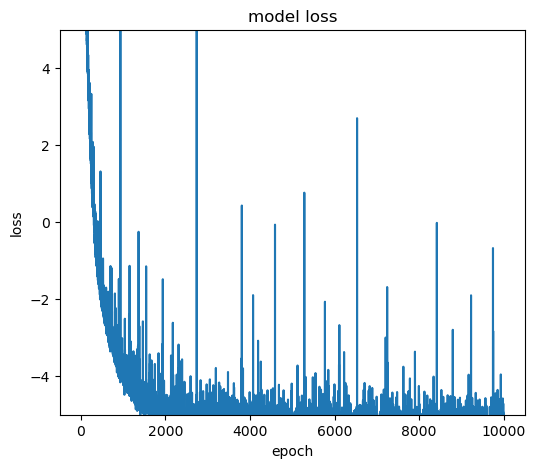

In [ ]:
if train:
    LossTrainL = history.history['loss'][-1]
    plt.figure(figsize=[6, 5])  # inches
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.ylim([-5.0, 5.0])
    plt.show()

In [ ]:
#%% Post=processing
runs = 50
x_pred_et = lambda_x
y_pred_et = lambda_y

In [ ]:
preds_ET =np.zeros((runs,2*len(x_pred_et)))
preds_ET_single =np.zeros((runs,2*len(x_pred_et),terms))
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(0,runs)):
    preds_ET[i,:]=np.reshape(model.predict([x_pred_et,y_pred_et]),2 * len(x_pred_et))
    for jj in range(terms):
        preds_ET_single[i,:,jj] = np.reshape([model_single.predict([x_pred_et,y_pred_et])[0][jj],model_single.predict([x_pred_et,y_pred_et])[1][jj]],2 * len(x_pred_et))

In [ ]:
preds_ETx=preds_ET[: , :len(lambda_x)]
preds_ETy=preds_ET[: , len(lambda_x):]
preds_ETx_single=preds_ET_single[: , :len(lambda_x),:]
preds_ETy_single=preds_ET_single[: , len(lambda_x):,:]

In [ ]:
preds_ETx_single.shape

In [ ]:
#%% Plotting

# plt.show()
def MapPlot(fig, axe, x_pred_ut, lam_UT, stress_ut, preds_UT, preds_UT_single, xlim, ylim, yticks, xticks, label, LabelFlag, TickFlag):
    cmap = plt.cm.get_cmap('jet_r',24)   # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap_r = list(reversed(cmaplist))

    if LabelFlag:
        axe.axvline(x=1, lw=0.5,alpha=0.5,color='k',zorder=1)
        axe.axhline(y=0, lw=0.5,alpha=0.5,color='k',zorder=1)
    All_pre = np.zeros((len(x_pred_ut),terms))
    for jj in range(terms):

        cur = np.mean(preds_UT_single[:,:,jj],axis=0).flatten()

        lower = np.sum(All_pre,axis=1)
        upper = lower + cur
        All_pre[:,jj] = cur

        axe.fill_between(x_pred_ut, lower.flatten(), upper.flatten(), lw=0,zorder=1, alpha=1.0, color=cmap_r[jj],label=f"Term {jj}")
        axe.plot(x_pred_ut, upper, lw=0.4, zorder=100, color='k',label=f"Term {jj}")

        axe.tick_params(axis='both', labelsize='xx-large')

    axe.plot(x_pred_ut,np.mean(preds_UT,axis=0),color="k",linewidth=2.0,zorder=100)
    axe.scatter(lam_UT, stress_ut, s=2 ,color="k", alpha=1.0, zorder=150, marker='.',label='data '+label) #observerd


    if not TickFlag:
        axe.set_xticklabels([])
        axe.set_yticklabels([])
    else:
        axe.set_xlabel(r'stretch $\lambda$ [-]',fontsize='xx-large')


    if LabelFlag:
        axe.set_ylabel(r'stress $\P$ [kPa]',fontsize='xx-large')
    divider = make_axes_locatable(axe)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axe.set_xlim(xlim)
    axe.set_ylim(ylim)
    axe.set_yticks(yticks)
    axe.set_xticks(xticks)
    norm = mpl.colors.Normalize(vmin=0, vmax=terms)
    tick_arr = list(np.flip(np.arange(terms))+0.5)
    tick_label = [r'$I_1$',r'$\exp(I_1)$',r'$I_1^2$',r'$\exp(I_1^2)$',
                  r'$I_2$',r'$\exp(I_2)$',r'$I_2^2$',r'$\exp(I_2^2)$',
                  r'$I_4$',r'$\exp(I_4)$',r'$I_4^2$',r'$\exp(I_4^2)$',
                  r'$I_5$',r'$\exp(I_5)$',r'$I_5^2$',r'$\exp(I_5^2)$',
                  r'$I_1*I_4$',r'$\exp(I_1*I_4)$',r'$I_1*I_5$',r'$\exp(I_1*I_5)$',
                  r'$I_2*I_4$',r'$\exp(I_2*I_4)$',r'$I_2*I_5$',r'$\exp(I_2*I_5)$']
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax,ticks=tick_arr, orientation='vertical',
                 label="", ax=fig_ax1)
    cax.set_yticklabels(tick_label,fontsize=10)
#%% Plotting

colR = (0./256,21./256,187./256,1.0)   #0015bb

def make_plot_runs_avg_full(ax,lam, x_pred, stress, preds, SetLabel, YTicks, Ylim, XTicks, Xlim, LabelFlag, YTIC):
    preds_mean = np.mean(preds, axis=0)

    # ✅ 计算 R²
    ss_total = np.sum((stress - np.mean(stress)) ** 2)  # 总方差
    ss_residual = np.sum((stress - np.interp(lam, x_pred, preds_mean)) ** 2)  # 残差平方和
    r2_score = 1 - (ss_residual / ss_total)

    # ✅ 在 `ax` 上绘制 R²
    ax.text(0.05, 0.9, f"$R^2 = {r2_score:.3f}$",
            transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    ax.plot(x_pred,np.mean(preds,axis=0),color=colR,linewidth=2.0,zorder=10)
    ax.scatter(lam, stress,color="k",s=2, alpha=1.0,zorder=5, marker='.',label=SetLabel) #observerd
    ax.fill_between(x_pred,np.quantile(preds, 0.025, axis=0), np.quantile(preds, 0.975, axis=0), lw=0,zorder=1, alpha=0.25, color=colR)

    if YTIC:
        ax.set_yticks(YTicks)
    else:
        ax.set_yticklabels([])
        ax.set_yticks([])

    if LabelFlag:
        ax.set_ylabel(r'stress $P$ [kPa]',fontsize='xx-large')

    ax.set_xticks(XTicks)
    ax.set_ylim(Ylim)
    ax.set_xlim(Xlim)
    # fig_ax0.legend(loc='upper left',ncol=1, fancybox=True, framealpha=0.,fontsize='xx-large')
    # fig_ax0.set_xlabel(r'stretch $\lambda$ [-]',fontsize='xx-large')
    ax.tick_params(axis='both', labelsize='xx-large')
    ax.set_xticklabels([])



lines = 5
xLim = 1.3

YTIC =True

#%% Plotting


In [ ]:
#%% Plotting

px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig =  plt.figure(figsize=(6000*px, 2600*px))


width_r = [3/5]*2

spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig, wspace=0.2, hspace=0.1, height_ratios=width_r)

fig_ax0 = fig.add_subplot(spec[0,0])
fig_ax1 = fig.add_subplot(spec[0,1])
#########################
##### Compression
#########################
# ax,lam, x_pred, stress, preds, SetLabel, YTicks, Ylim, XTicks, Xlim, LabelFlag, YTIC
# YTicks, Ylim, XTicks, Xlim, YTIC
make_plot_runs_avg_full(fig_ax0,lambda_x, x_pred_et, sigma_xx, preds_ETx, 'x', [], [-0.01, 0.07], [], [0.99, 1.05],False, YTIC)

#########################
##### Tension
#########################
make_plot_runs_avg_full(fig_ax1,lambda_y, y_pred_et, sigma_yy, preds_ETy, 'y', [], [-0.01, 0.07], [], [0.99, 1.02],False,YTIC)
plt.savefig(path2saveResults+'/results_map0.pdf')

In [ ]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig =  plt.figure(figsize=(6000*px, 2600*px))
width_r = [3/5]*2
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig, wspace=0.2, hspace=0.1, height_ratios=width_r)
ax0 = fig.add_subplot(spec[1,0])
ax1 = fig.add_subplot(spec[1,1])

MapPlot(fig, ax0, x_pred_et, lambda_x, sigma_xx, preds_ETx, preds_ETx_single, [0.99, 1.05], [-0.01, 0.07], [-0.01, 0.07], [0.99, 1.05], "w",True,YTIC)
MapPlot(fig, ax1, y_pred_et, lambda_y, sigma_yy, preds_ETy, preds_ETy_single, [0.99, 1.02], [-0.01, 0.07], [-0.01, 0.07], [0.99, 1.02], "y",True,YTIC)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(path2saveResults+'/results_map1.pdf')

In [ ]:
Model_summary = path2saveResults_0 + '/Model_summary.txt'